# Model load

In [1]:
import google.colab.drive as drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import random
import torch
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader
from matplotlib.patches import Ellipse
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
from torchvision.transforms import transforms
from scipy.spatial.distance import mahalanobis
from sklearn.preprocessing import StandardScaler
from torch.distributions import Normal, kl_divergence
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, classification_report

os.chdir("/content/drive/MyDrive/Colab Notebooks/Self_Study/ZClassifier")

In [3]:
from models import *
from models import ZClassifier, SoftmaxClassifier, ResNetFeature, VGGFeature

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
path = "/content/drive/MyDrive/Colab Notebooks/Self_Study/ZClassifier/pretrained"
def load_model(model_class, path, device='cpu', **model_kwargs):
    """
    Load a model from a state_dict.

    Args:
        model_class (callable): Class of the model to instantiate (e.g., ZClassifier)
        path (str): File path to .pth file
        device (str): 'cuda' or 'cpu'
        model_kwargs: keyword arguments passed to model_class

    Returns:
        nn.Module: Loaded model
    """
    model = model_class(**model_kwargs)
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    print(f"[✓] Loaded model from: {path}")
    return model

In [5]:
modelA = load_model(
    model_class=ZClassifier,
    path=f'{path}/modelA.pth',
    device=device,
    feature_extractor=ResNetFeature(), num_classes=100, latent_dim=60, beta=1.0
)

modelB = load_model(
    model_class=ZClassifier,
    path=f'{path}/modelB.pth',
    device=device,
    feature_extractor=VGGFeature(), num_classes=100, latent_dim=60, beta=1.0
)
softmax_model = load_model(
    model_class=SoftmaxClassifier,
    path=f'{path}/softmax_model.pth',
    device=device,
    feature_extractor=ResNetFeature(), num_classes=100
)

nokl_model = load_model(
    model_class=ZClassifier,
    path=f'{path}/model_nokl.pth',
    device=device,
    feature_extractor=ResNetFeature(), num_classes=100, latent_dim=60, beta=1.0
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 17.1MB/s]


[✓] Loaded model from: /content/drive/MyDrive/Colab Notebooks/Self_Study/ZClassifier/pretrained/modelA.pth


Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:15<00:00, 34.5MB/s]


[✓] Loaded model from: /content/drive/MyDrive/Colab Notebooks/Self_Study/ZClassifier/pretrained/modelB.pth
[✓] Loaded model from: /content/drive/MyDrive/Colab Notebooks/Self_Study/ZClassifier/pretrained/softmax_model.pth
[✓] Loaded model from: /content/drive/MyDrive/Colab Notebooks/Self_Study/ZClassifier/pretrained/model_nokl.pth


In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load CIFAR-10 train set for training
cifar10 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(cifar10, batch_size=100, shuffle=True)


# Load CIFAR-10 test set for analysis
cifar10 = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
eval_loader = DataLoader(cifar10, batch_size=100, shuffle=False)
test_loader = DataLoader(cifar10, batch_size=100, shuffle=False)

## 1. **Calibration Robustness under Logit Perturbation**

Test ZClassifier's robustness to softmax calibration under Gaussian logit noise.


In [7]:
def evaluate_calibration_with_noise(model, test_loader, noise_std_list):
    model.eval()
    results = []

    with torch.no_grad():
        for noise_std in noise_std_list:
            correct, total = 0, 0
            all_probs, all_labels = [], []

            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                logits = model(images)
                noise = torch.randn_like(logits) * noise_std * logits.std()
                noisy_logits = logits + noise

                probs = F.softmax(noisy_logits, dim=1)
                preds = probs.argmax(dim=1)

                correct += (preds == labels).sum().item()
                total += labels.size(0)
                all_probs.append(probs.cpu())
                all_labels.append(labels.cpu())

            acc = correct / total
            print(f"Noise STD: {noise_std:.2f} → Accuracy: {acc:.4f}")
            results.append((noise_std, acc))

    return results

def plot_calibration_results(results_dict):

    records = []
    for model_name, results in results_dict.items():
        for noise_std, acc in results:
            records.append({
                'Model': model_name,
                'Noise STD': float(noise_std),
                'Accuracy': float(acc)
            })

    df = pd.DataFrame.from_records(records)
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=df, x='Noise STD', y='Accuracy', hue='Model', marker='o')
    plt.title('Calibration Robustness under Logit Noise')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [8]:
noises = np.linspace(0, 2, num=20, endpoint=True).tolist()

In [9]:
# 가정: 4개의 모델은 이미 device에 로드되어 있고, test_loader도 준비된 상태
noise_std_list = torch.linspace(0.0, 2.0, steps=10)

results_dict = {}

# 각 모델에 대해 평가 수행
print('ResNet ZClassifier Calibration')
results_dict['ResNet ZClassifier'] = evaluate_calibration_with_noise(modelA, test_loader, noise_std_list)
print('VGG ZClassifier Calibration')
results_dict['VGG ZClassifier'] = evaluate_calibration_with_noise(modelB, test_loader, noise_std_list)
print('Softmax Classifier Calibration')
results_dict['Softmax Classifier'] = evaluate_calibration_with_noise(softmax_model, test_loader, noise_std_list)
print('NoKL ZClassifier Calibration')
results_dict['NoKL ZClassifier'] = evaluate_calibration_with_noise(nokl_model, test_loader, noise_std_list)

ResNet ZClassifier Calibration
Noise STD: 0.00 → Accuracy: 0.7301
Noise STD: 0.22 → Accuracy: 0.7291
Noise STD: 0.44 → Accuracy: 0.7291
Noise STD: 0.67 → Accuracy: 0.7255
Noise STD: 0.89 → Accuracy: 0.7237
Noise STD: 1.11 → Accuracy: 0.7163
Noise STD: 1.33 → Accuracy: 0.7118
Noise STD: 1.56 → Accuracy: 0.7052
Noise STD: 1.78 → Accuracy: 0.6917
Noise STD: 2.00 → Accuracy: 0.6757
VGG ZClassifier Calibration
Noise STD: 0.00 → Accuracy: 0.6197
Noise STD: 0.22 → Accuracy: 0.6169
Noise STD: 0.44 → Accuracy: 0.6141
Noise STD: 0.67 → Accuracy: 0.6065
Noise STD: 0.89 → Accuracy: 0.5959
Noise STD: 1.11 → Accuracy: 0.5737
Noise STD: 1.33 → Accuracy: 0.5578
Noise STD: 1.56 → Accuracy: 0.5341
Noise STD: 1.78 → Accuracy: 0.5137
Noise STD: 2.00 → Accuracy: 0.4742
Softmax Classifier Calibration
Noise STD: 0.00 → Accuracy: 0.7301
Noise STD: 0.22 → Accuracy: 0.7146
Noise STD: 0.44 → Accuracy: 0.6821
Noise STD: 0.67 → Accuracy: 0.6302
Noise STD: 0.89 → Accuracy: 0.5710
Noise STD: 1.11 → Accuracy: 0.4947


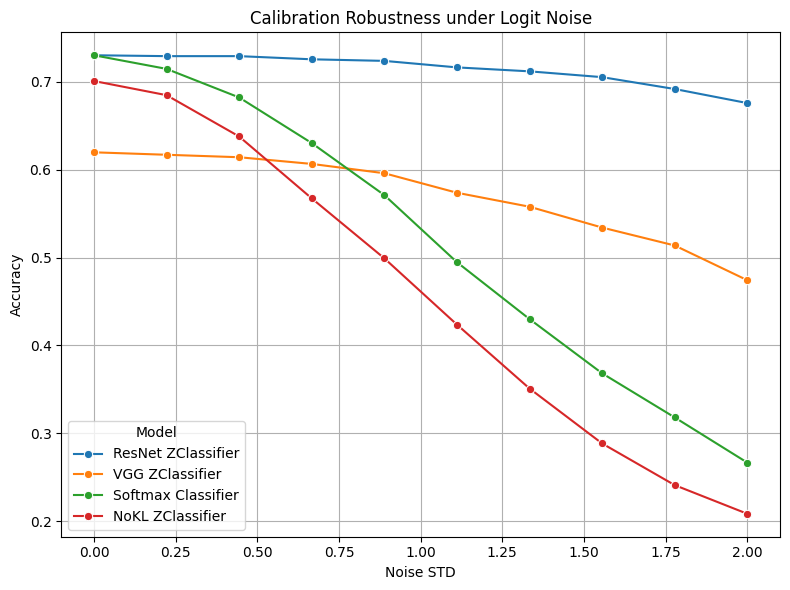

In [10]:
plot_calibration_results(results_dict)

## 2. **Latent Logit Geometry Consistency**




Compare latent structure between backbones (e.g., ResNet vs VGG).

### PCA on train set
Most general linear dimensionality reduction.

In [11]:
def visualize_latent_geometry(model, dataloader, name, num_batches=100):
    model.eval()
    all_latents, all_labels = [], []

    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader):
            if i >= num_batches: break
            images = images.to(device)
            z = model(images)
            z_flat = z.view(z.size(0), -1)
            all_latents.append(z_flat.cpu())
            all_labels.append(labels)

    X = torch.cat(all_latents, dim=0).numpy()
    y = torch.cat(all_labels, dim=0).numpy()

    X_pca = PCA(n_components=2).fit_transform(X)
    plt.figure(figsize=(10, 10))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='tab10', legend=False)
    plt.title(f"PCA of {name} Latent Logit Space")
    plt.grid(True)
    plt.show()

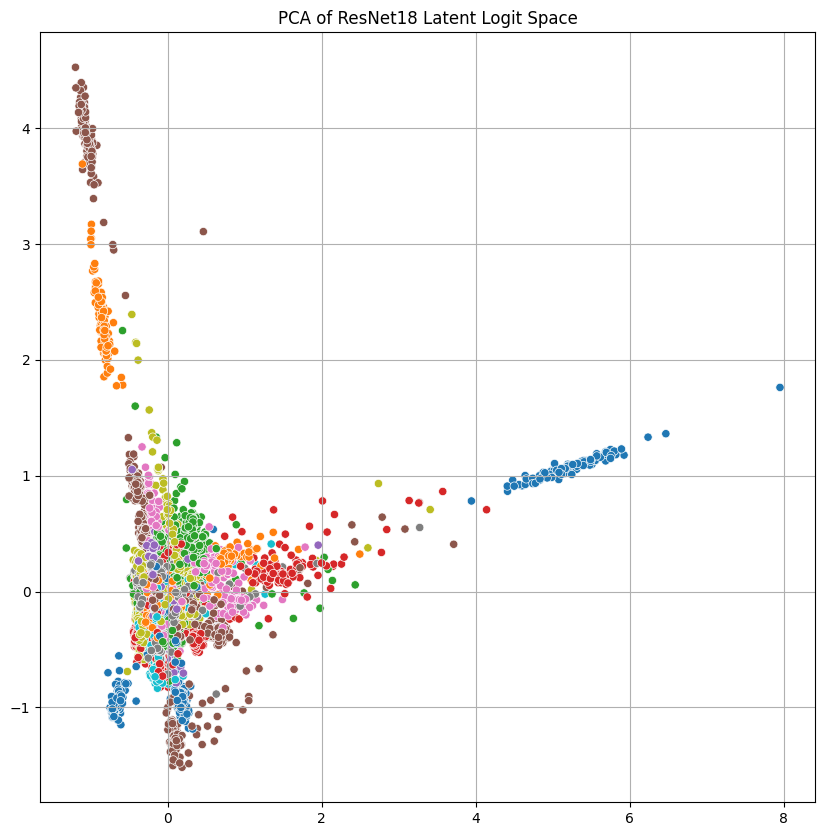

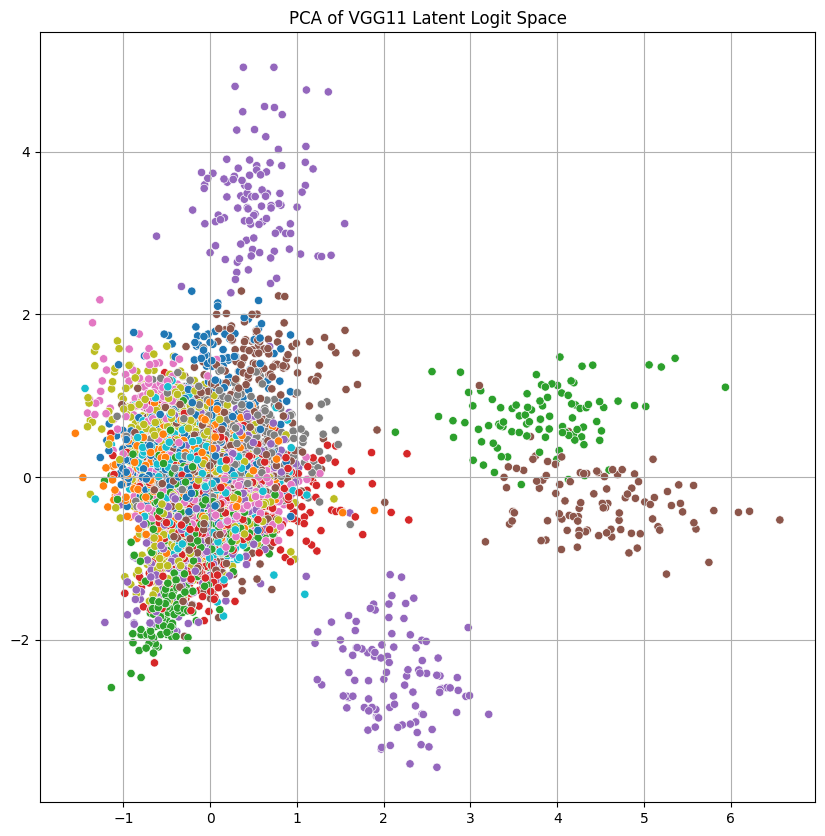

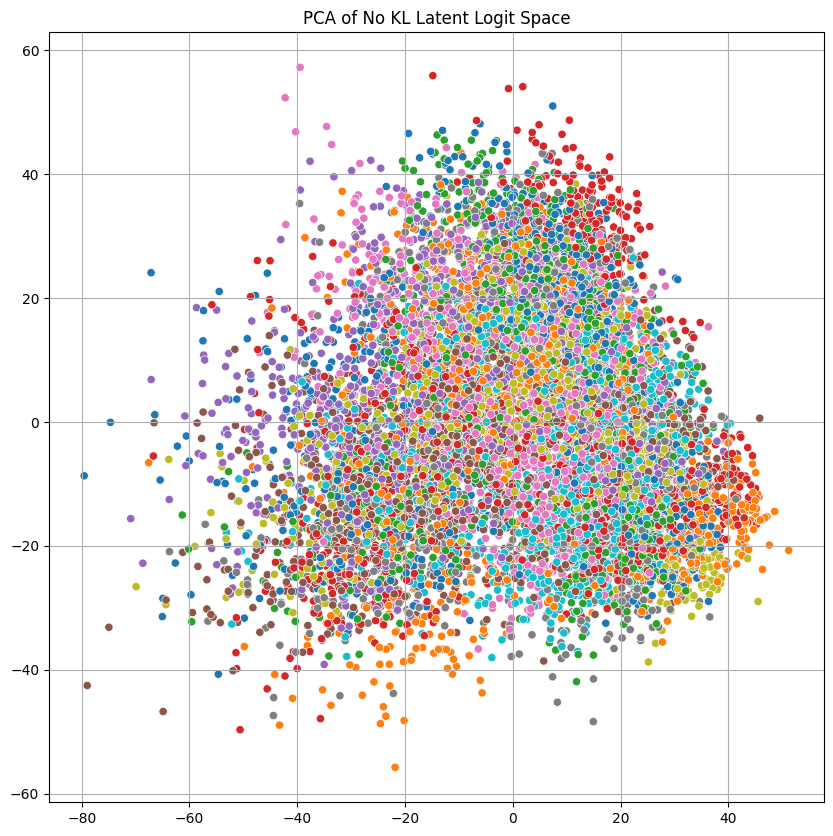

In [12]:
visualize_latent_geometry(modelA, train_loader, name="ResNet18")
visualize_latent_geometry(modelB, train_loader, name="VGG11")
visualize_latent_geometry(softmax_model, train_loader, name="Softmax")
visualize_latent_geometry(nokl_model, train_loader, name="No KL")

### t-SNE

In [13]:
def simulate_latents(model_type='resnet', n_samples=1000, batch_size=100, seed=42):

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 1. Data load
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Fit to VGG/ResNet input size
        transforms.ToTensor(),
    ])
    cifar10 = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
    loader = DataLoader(cifar10, batch_size=batch_size, shuffle=False)

    # 2. Load pretrianed models
    if model_type == 'resnet':
        model = modelA
    elif model_type == 'vgg':
        model = modelB
    elif model_type == 'softmax':
        model = softmax_model
    elif model_type == 'nokl':
        model = nokl_model
    else:
        raise ValueError("model_type must be one of: ['resnet', 'vgg', 'softmax', 'nokl']")

    model.eval()

    # 3. Logits
    all_latents = []
    all_labels = []

    with torch.no_grad():
        for x, y in tqdm(loader, desc=f"Simulating {model_type}"):
            x = x.to(device)
            z = model(x).detach().cpu()

            all_latents.append(z)
            all_labels.append(y)

    all_latents = torch.cat(all_latents, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()
    return all_latents, all_labels


# 2. Simulate latent logit outputs
resnet_latents, resnet_labels = simulate_latents('resnet')
vgg_latents, vgg_labels = simulate_latents('vgg')
softmax_latents, softmax_labels = simulate_latents('softmax')
nokl_latents, nokl_labels = simulate_latents('nokl')

Simulating resnet:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating vgg:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating softmax:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating nokl:   0%|          | 0/100 [00:00<?, ?it/s]

In [14]:
def plot_tsne(features, labels, title="t-SNE Embedding"):
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, max_iter=1000, random_state=42)
    features_2d = tsne.fit_transform(features)

    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='tab10', s=10, alpha=0.6)
    plt.legend(*scatter.legend_elements(), title="Class")
    plt.title(title)
    plt.grid(True)
    plt.show()


In [15]:
# features: latent vector (e.g. model.z.mean(-1).detach().cpu().numpy())
# labels: ground-truth class labels
plot_tsne(resnet_latents, resnet_labels, title="ResNet18 - t-SNE Embedding")
plot_tsne(vgg_latents, vgg_labels, title="VGG11 - t-SNE Embedding")
plot_tsne(softmax_latents, softmax_labels, title="Softmax - t-SNE Embedding")
plot_tsne(nokl_latents, nokl_labels, title="NoKL - t-SNE Embedding")

Output hidden; open in https://colab.research.google.com to view.

### Fisher LDA

In [16]:
def plot_fisher_lda(features, labels, title="Fisher LDA Embedding"):
    lda = LDA(n_components=2)
    features_2d = lda.fit_transform(features, labels)

    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='tab10', s=10, alpha=0.6)
    plt.title(title)
    plt.legend(*scatter.legend_elements(), title="Class")
    plt.grid(True)
    plt.show()

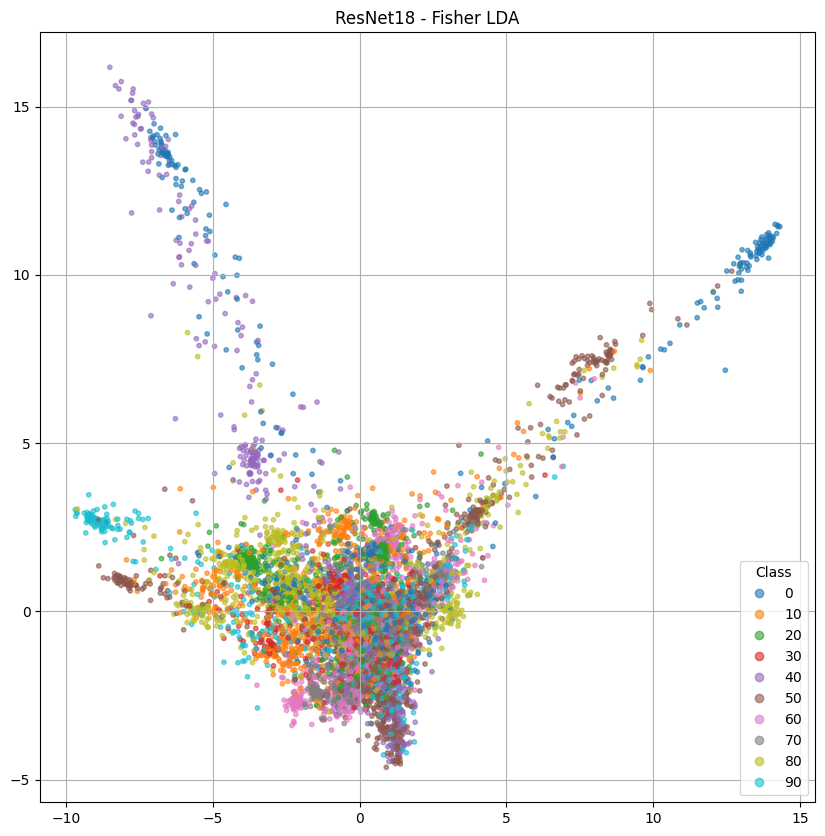

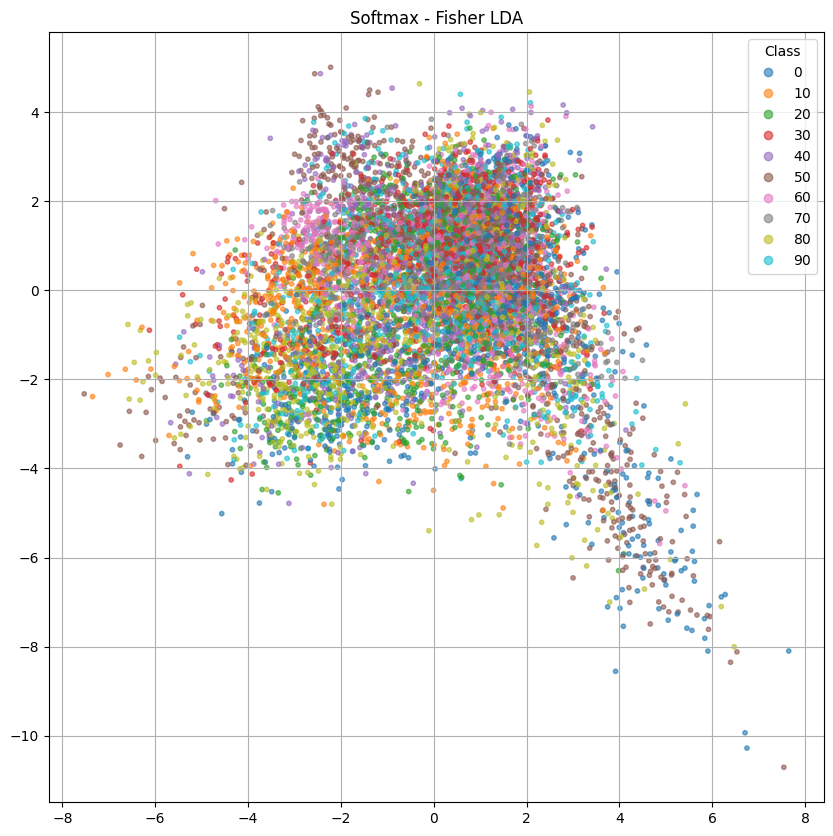

In [17]:
plot_fisher_lda(resnet_latents, resnet_labels, title="ResNet18 - Fisher LDA")
plot_fisher_lda(vgg_latents, vgg_labels, title="VGG11 - Fisher LDA")
plot_fisher_lda(softmax_latents, softmax_labels, title="Softmax - Fisher LDA")
plot_fisher_lda(nokl_latents, nokl_labels, title="NoKL - Fisher LDA")

### PCA on validation set

In [18]:
def plot_classwise_pca(latents, labels, model_name='Model'):
    pca = PCA(n_components=2)
    z2d = pca.fit_transform(latents)

    plt.figure(figsize=(10, 10))
    sns.scatterplot(x=z2d[:, 0], y=z2d[:, 1], hue=labels, palette='tab10', s=30, alpha=0.8, legend=False)
    plt.title(f'PCA of Latent Logit Space ({model_name})')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True)
    plt.show()


In [19]:
plot_classwise_pca(resnet_latents, resnet_labels, model_name='ResNet ZClassifier')
plot_classwise_pca(vgg_latents, vgg_labels, model_name='VGG ZClassifier')
plot_classwise_pca(softmax_latents, softmax_labels, model_name='Softmax Classifier')
plot_classwise_pca(nokl_latents, nokl_labels, model_name='NoKL ZClassifier')

Output hidden; open in https://colab.research.google.com to view.

### GMM Ellipsis with PCA

In [20]:
def plot_gmm_ellipses(z_all, labels_all, name, n_components=10):
    N, C = z_all.shape

    # 2D PCA
    z_2d = PCA(n_components=2).fit_transform(z_all)

    # GMM
    gmm = GaussianMixture(n_components=n_components, covariance_type='full')
    gmm.fit(z_2d)

    # Ellipsis
    sns.jointplot(x=z_2d[:, 0], y=z_2d[:, 1],
                  height=10,
                  s=5, hue=labels_all, alpha=0.6,
                  palette="coolwarm")

    for i in range(n_components):
        mean = gmm.means_[i]
        cov = gmm.covariances_[i]
        eigvals, eigvecs = np.linalg.eigh(cov)
        angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
        width, height = 2 * np.sqrt(eigvals)

        ell = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor='k', facecolor='none')
        plt.gca().add_patch(ell)

    plt.title(f"GMM Ellipses over {name} Logits (PCA 2D)")
    plt.xlabel("PC-1")
    plt.ylabel("PC-2")
    plt.legend(title='Class')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


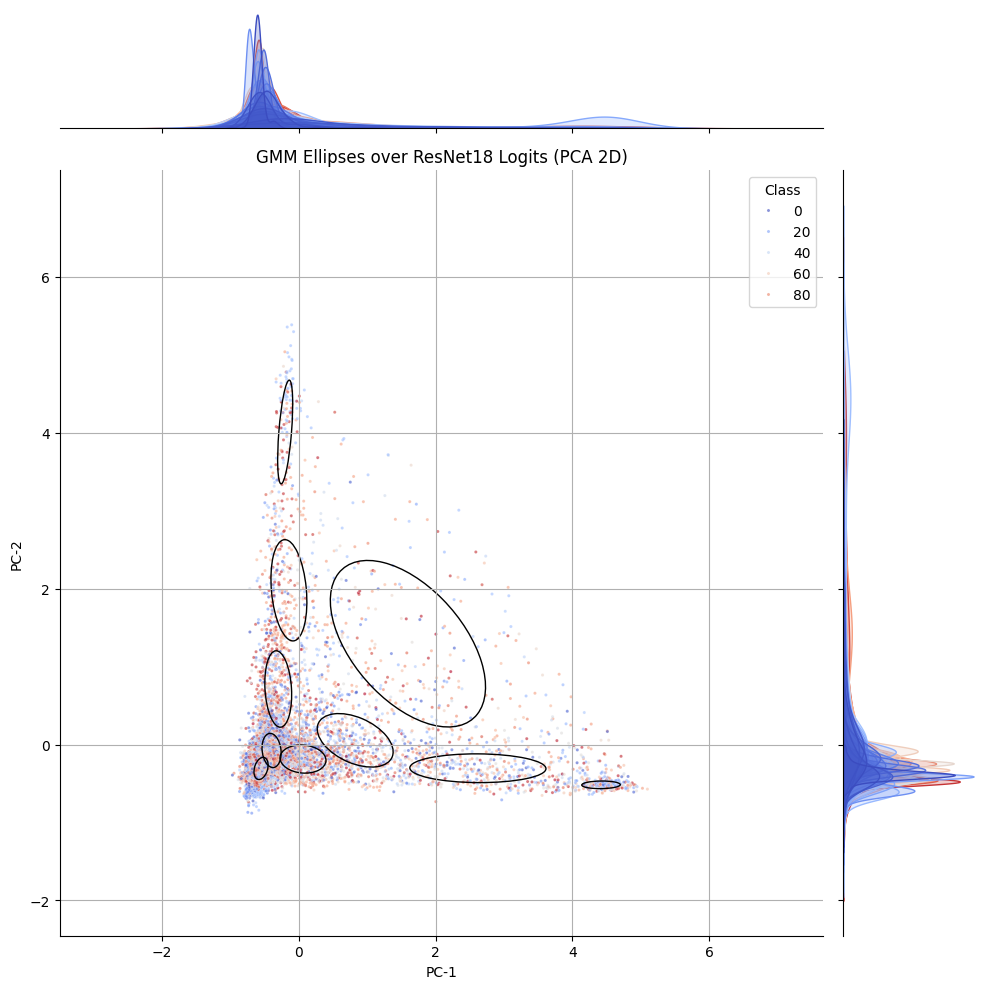

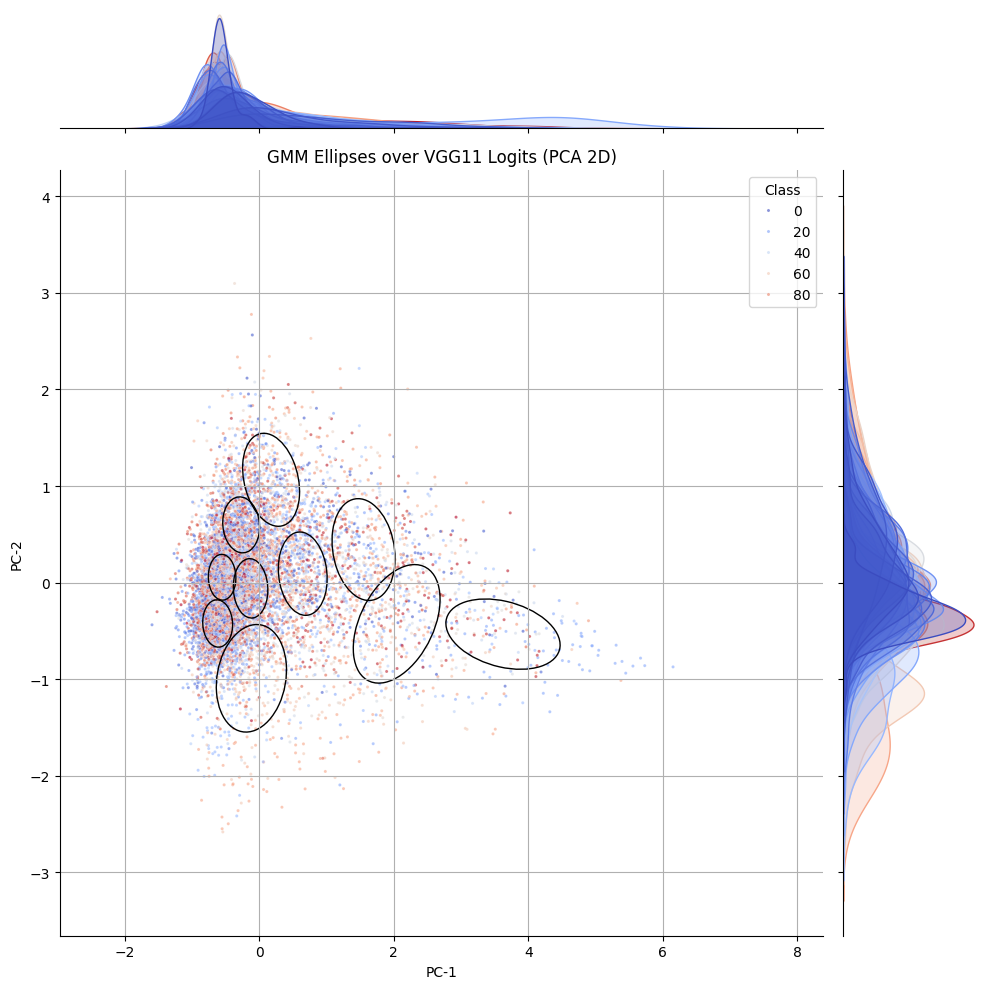

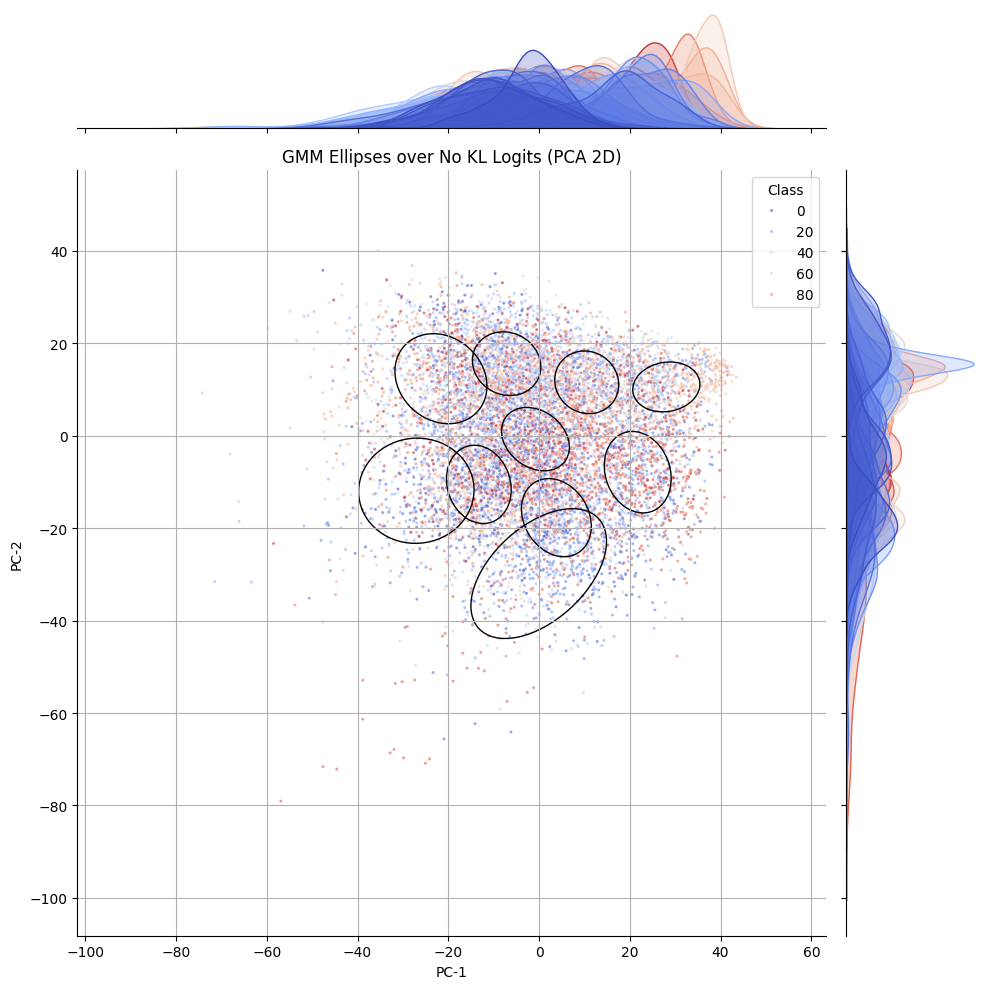

In [21]:
plot_gmm_ellipses(resnet_latents, resnet_labels, name="ResNet18")
plot_gmm_ellipses(vgg_latents, vgg_labels, name="VGG11")
plot_gmm_ellipses(softmax_latents, softmax_labels, name="Softmax")
plot_gmm_ellipses(nokl_latents, nokl_labels, name="No KL")

## 3. **OOD Detection via KL Score**

Use the KL divergence to the closest one-hot Gaussian to detect OOD samples.
`SoftmaxClassifier` doesn't outputs distributions or random vectors, so it is out of the evalutaions.

In [22]:
def compute_kl_scores(mu, logvar):
    """
    KL divergence between N(mu, sigma^2) and N(0,1)
    """
    var = logvar.exp()
    std_normal = Normal(torch.zeros_like(mu), torch.ones_like(var))
    pred_normal = Normal(mu, var.sqrt())
    kl = kl_divergence(pred_normal, std_normal)  # shape: [batch, classes]
    return kl.mean(dim=(1, 2))  # [batch]

def evaluate_ood_score(in_scores, ood_scores):
    labels = np.array([1] * len(in_scores) + [0] * len(ood_scores))  # 1: In, 0: OOD
    scores = np.concatenate([in_scores, ood_scores])

    # Check if labels are binary
    unique_labels = np.unique(labels)
    if not np.all(np.sort(unique_labels) == [0, 1]):
        raise ValueError(f"Labels must be binary (0 or 1), but found: {unique_labels}")

    # Add small noise to scores if all are identical
    if len(np.unique(scores)) == 1:
        scores = scores + np.random.rand(len(scores)) * 1e-6

    auroc = roc_auc_score(labels, -scores)
    aupr = average_precision_score(labels, -scores)

    # Ensure fpr and tpr are calculated correctly for binary classification
    fpr, tpr, _ = roc_curve(labels, -scores)
    # Find FPR at 95% TPR, handling cases where TPR doesn't reach 95%
    if np.any(tpr >= 0.95):
        fpr95 = fpr[np.argmax(tpr >= 0.95)]
    else:
        fpr95 = 1.0 # If TPR never reaches 95%, FPR@95 is 1.0

    return {'AUROC': auroc, 'AUPR': aupr, 'FPR@95': fpr95}, labels, scores

def evaluate_ood_detection(model, in_loader, ood_loader, device=device):
    model.eval()
    in_scores, ood_scores = [], []

    with torch.no_grad():
        for images, _ in in_loader:
            images = images.to(device)
            _ = model(images)
            mu, logvar = model.mu.clone(), model.logvar.clone()
            kl = compute_kl_scores(mu, logvar)
            in_scores.extend(kl.cpu().numpy())

        for images, _ in ood_loader:
            images = images.to(device)
            _ = model(images)
            mu, logvar = model.mu.clone(), model.logvar.clone()
            kl = compute_kl_scores(mu, logvar)
            ood_scores.extend(kl.cpu().numpy())

    # metrics
    metrics, labels, scores = evaluate_ood_score(in_scores, ood_scores)

    in_scores = np.array(in_scores)
    ood_scores = np.array(ood_scores)

    # report
    # Use a percentile that exists within the data
    if len(in_scores) > 0:
        threshold = np.percentile(-in_scores, min(5, 100))  # conservative thresholding (5% percentile)
    else:
        threshold = -np.inf # If no in-distribution scores, threshold is effectively negative infinity

    predicted = (-np.array(scores) > threshold).astype(int)
    report = classification_report(labels, predicted, target_names=['OOD', 'In-Distribution'])

    print("📊 OOD Detection Performance:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    print("\n📋 Classification Report (Threshold = {:.4f}):".format(threshold))
    print(report)

    # visualize
    plt.hist(in_scores, bins=50, density=True, alpha=0.5, label="In-Distribution")
    plt.hist(ood_scores, bins=50, density=True, alpha=0.5, label="Out-of-Distribution")
    plt.title("KL Divergence Scores for OOD Detection")
    plt.xlabel("KL Score")
    plt.ylabel("Count")
    plt.legend()
    plt.show()

    return metrics

In [23]:
from torchvision.datasets import SVHN
from torchvision.datasets import CIFAR10

class SyntheticNoiseDataset(torch.utils.data.Dataset):
    def __init__(self, kind='gaussian', size=10000, image_shape=(3, 32, 32)):
        self.kind = kind
        self.size = size
        self.image_shape = image_shape

    def __getitem__(self, idx):
        if self.kind == 'gaussian':
            img = torch.randn(self.image_shape)
        elif self.kind == 'uniform':
            img = torch.rand(self.image_shape)
        else:
            raise ValueError("Unsupported noise type.")
        return img, 0  # dummy label

    def __len__(self):
        return self.size

def get_noise_loader(kind='gaussian', batch_size=100):
    dataset = SyntheticNoiseDataset(kind=kind)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)

def get_svhn_loader(batch_size=100):
    transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
    svhn = SVHN(root='./data', split='test', download=True, transform=transform)
    return DataLoader(svhn, batch_size=batch_size, shuffle=False)

def get_cifar10_loader(batch_size=100):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                             std=[0.2023, 0.1994, 0.2010])
    ])
    cifar10 = CIFAR10(root='./data', train=False, download=True, transform=transform)
    return DataLoader(cifar10, batch_size=batch_size, shuffle=False)

In [24]:
ood_svhn = get_svhn_loader()
ood_gaussian = get_noise_loader('gaussian')
ood_uniform = get_noise_loader('uniform')
ood_cifar10 = get_cifar10_loader()

📊 OOD Detection Performance:
AUROC: 1.0000
AUPR: 1.0000
FPR@95: 0.0000

📋 Classification Report (Threshold = -3.2196):
                 precision    recall  f1-score   support

            OOD       0.98      1.00      0.99     26032
In-Distribution       1.00      0.95      0.97     10000

       accuracy                           0.99     36032
      macro avg       0.99      0.97      0.98     36032
   weighted avg       0.99      0.99      0.99     36032



📊 OOD Detection Performance:
AUROC: 0.9682
AUPR: 0.8921
FPR@95: 0.1063

📋 Classification Report (Threshold = -3.4704):
                 precision    recall  f1-score   support

            OOD       0.98      0.89      0.93     26032
In-Distribution       0.77      0.95      0.85     10000

       accuracy                           0.91     36032
      macro avg       0.88      0.92      0.89     36032
   weighted avg       0.92      0.91      0.91     36032



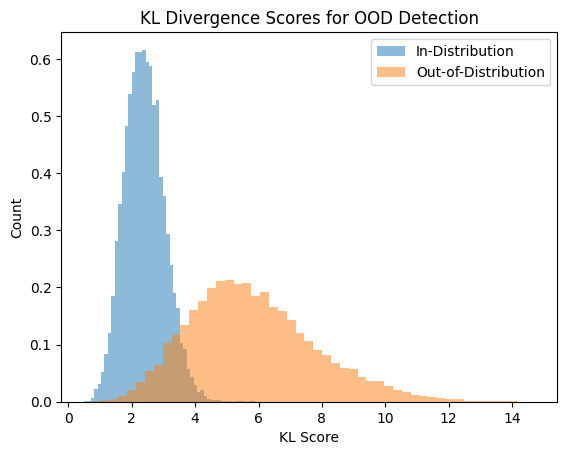

📊 OOD Detection Performance:
AUROC: 0.0000
AUPR: 0.1538
FPR@95: 1.0000

📋 Classification Report (Threshold = -85.8196):
                 precision    recall  f1-score   support

            OOD       0.00      0.00      0.00     26032
In-Distribution       0.27      0.95      0.42     10000

       accuracy                           0.26     36032
      macro avg       0.13      0.47      0.21     36032
   weighted avg       0.07      0.26      0.12     36032



{'AUROC': np.float64(0.0),
 'AUPR': np.float64(0.1537633476382693),
 'FPR@95': np.float64(1.0)}

In [25]:
evaluate_ood_detection(modelA, eval_loader, ood_svhn)
evaluate_ood_detection(modelB, eval_loader, ood_svhn)
evaluate_ood_detection(nokl_model, eval_loader, ood_svhn)

📊 OOD Detection Performance:
AUROC: 1.0000
AUPR: 1.0000
FPR@95: 0.0000

📋 Classification Report (Threshold = -3.2196):
                 precision    recall  f1-score   support

            OOD       0.95      1.00      0.98     10000
In-Distribution       1.00      0.95      0.97     10000

       accuracy                           0.97     20000
      macro avg       0.98      0.97      0.97     20000
   weighted avg       0.98      0.97      0.97     20000



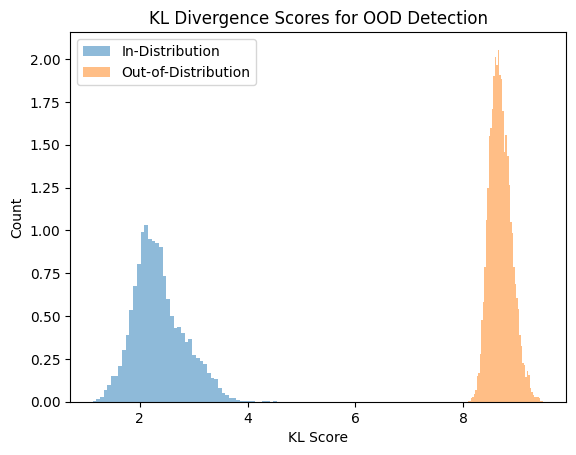

📊 OOD Detection Performance:
AUROC: 1.0000
AUPR: 1.0000
FPR@95: 0.0000

📋 Classification Report (Threshold = -3.4704):
                 precision    recall  f1-score   support

            OOD       0.95      1.00      0.98     10000
In-Distribution       1.00      0.95      0.97     10000

       accuracy                           0.97     20000
      macro avg       0.98      0.97      0.97     20000
   weighted avg       0.98      0.97      0.97     20000



📊 OOD Detection Performance:
AUROC: 0.0000
AUPR: 0.3069
FPR@95: 1.0000

📋 Classification Report (Threshold = -85.8196):
                 precision    recall  f1-score   support

            OOD       0.00      0.00      0.00     10000
In-Distribution       0.49      0.95      0.64     10000

       accuracy                           0.47     20000
      macro avg       0.24      0.47      0.32     20000
   weighted avg       0.24      0.47      0.32     20000



{'AUROC': np.float64(0.0),
 'AUPR': np.float64(0.3068778611725624),
 'FPR@95': np.float64(1.0)}

In [26]:
evaluate_ood_detection(modelA, eval_loader, ood_gaussian)
evaluate_ood_detection(modelB, eval_loader, ood_gaussian)
evaluate_ood_detection(nokl_model, eval_loader, ood_gaussian)

📊 OOD Detection Performance:
AUROC: 1.0000
AUPR: 1.0000
FPR@95: 0.0000

📋 Classification Report (Threshold = -3.2196):
                 precision    recall  f1-score   support

            OOD       0.95      1.00      0.98     10000
In-Distribution       1.00      0.95      0.97     10000

       accuracy                           0.97     20000
      macro avg       0.98      0.97      0.97     20000
   weighted avg       0.98      0.97      0.97     20000



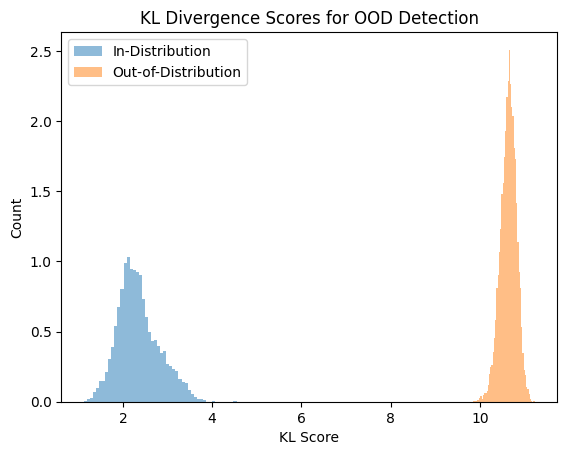

📊 OOD Detection Performance:
AUROC: 0.9997
AUPR: 0.9997
FPR@95: 0.0000

📋 Classification Report (Threshold = -3.4704):
                 precision    recall  f1-score   support

            OOD       0.95      1.00      0.98     10000
In-Distribution       1.00      0.95      0.97     10000

       accuracy                           0.97     20000
      macro avg       0.98      0.97      0.97     20000
   weighted avg       0.98      0.97      0.97     20000



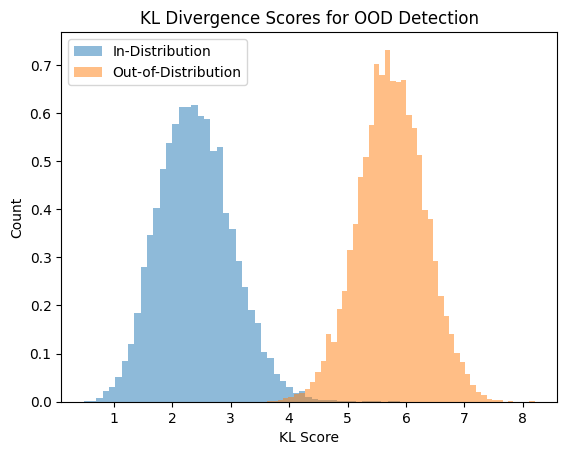

📊 OOD Detection Performance:
AUROC: 0.0000
AUPR: 0.3069
FPR@95: 1.0000

📋 Classification Report (Threshold = -85.8196):
                 precision    recall  f1-score   support

            OOD       0.00      0.00      0.00     10000
In-Distribution       0.49      0.95      0.64     10000

       accuracy                           0.47     20000
      macro avg       0.24      0.47      0.32     20000
   weighted avg       0.24      0.47      0.32     20000



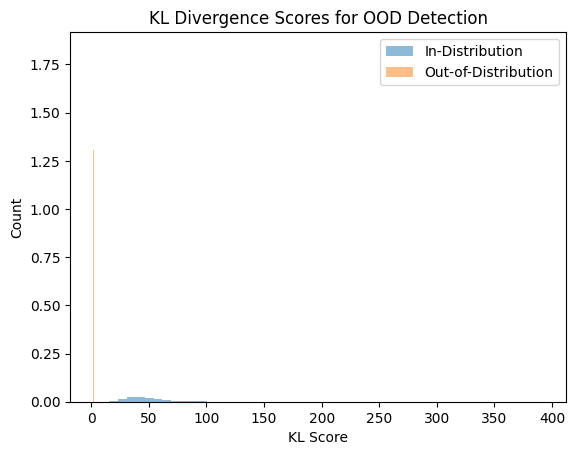

{'AUROC': np.float64(0.0),
 'AUPR': np.float64(0.3068778611725624),
 'FPR@95': np.float64(1.0)}

In [27]:
evaluate_ood_detection(modelA, eval_loader, ood_uniform)
evaluate_ood_detection(modelB, eval_loader, ood_uniform)
evaluate_ood_detection(nokl_model, eval_loader, ood_uniform)

📊 OOD Detection Performance:
AUROC: 1.0000
AUPR: 1.0000
FPR@95: 0.0000

📋 Classification Report (Threshold = -3.2196):
                 precision    recall  f1-score   support

            OOD       0.95      1.00      0.98     10000
In-Distribution       1.00      0.95      0.97     10000

       accuracy                           0.97     20000
      macro avg       0.98      0.97      0.97     20000
   weighted avg       0.98      0.97      0.97     20000



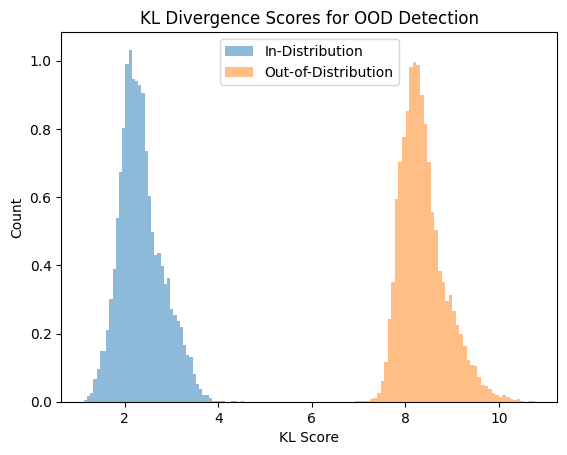

📊 OOD Detection Performance:
AUROC: 0.9897
AUPR: 0.9835
FPR@95: 0.0331

📋 Classification Report (Threshold = -3.4704):
                 precision    recall  f1-score   support

            OOD       0.95      0.97      0.96     10000
In-Distribution       0.97      0.95      0.96     10000

       accuracy                           0.96     20000
      macro avg       0.96      0.96      0.96     20000
   weighted avg       0.96      0.96      0.96     20000



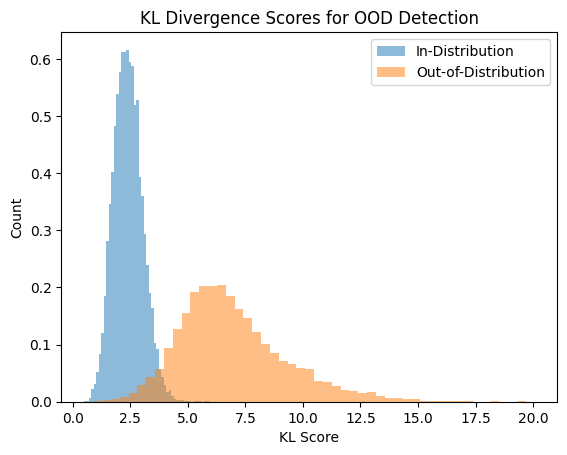

📊 OOD Detection Performance:
AUROC: 0.0000
AUPR: 0.3069
FPR@95: 1.0000

📋 Classification Report (Threshold = -85.8196):
                 precision    recall  f1-score   support

            OOD       0.00      0.00      0.00     10000
In-Distribution       0.49      0.95      0.64     10000

       accuracy                           0.47     20000
      macro avg       0.24      0.47      0.32     20000
   weighted avg       0.24      0.47      0.32     20000



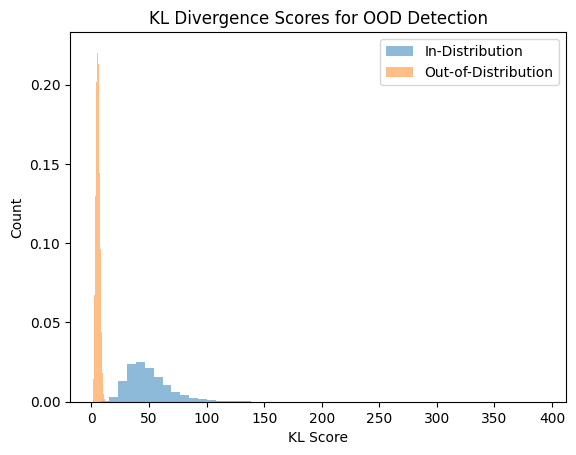

{'AUROC': np.float64(1.4829999999999987e-05),
 'AUPR': np.float64(0.306877864366608),
 'FPR@95': np.float64(1.0)}

In [28]:
evaluate_ood_detection(modelA, eval_loader, ood_cifar10)
evaluate_ood_detection(modelB, eval_loader, ood_cifar10)
evaluate_ood_detection(nokl_model, eval_loader, ood_cifar10)